In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

import plotly.express as px
import plotly.graph_objects as go

import pingouin as pg

from geopy.distance import geodesic as GD

import haversine as hs
from haversine import Unit

import datetime

/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/code/madrid_iot/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [668]:
df = pd.read_csv('/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/2022-09-madrid-trafficcsv.csv',
                 sep = ';')

In [669]:
df = df.iloc[:20, :]

In [670]:
df

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1001,2022-09-01 00:00:00,M30,1020,2.0,0,63.0,N,5
1,1001,2022-09-01 00:15:00,M30,984,2.0,0,62.0,N,5
2,1001,2022-09-01 00:30:00,M30,840,2.0,0,59.0,N,5
3,1001,2022-09-01 00:45:00,M30,840,2.0,0,59.0,N,5
4,1001,2022-09-01 01:00:00,M30,840,2.0,0,59.0,N,5
5,1001,2022-09-01 01:15:00,M30,840,2.0,0,59.0,N,5
6,1001,2022-09-01 01:30:00,M30,840,2.0,0,59.0,N,5
7,1001,2022-09-01 01:45:00,M30,840,2.0,0,59.0,N,5
8,1001,2022-09-01 02:00:00,M30,840,2.0,0,59.0,N,5
9,1001,2022-09-01 02:15:00,M30,840,2.0,0,59.0,N,5


In [22]:
a = pd.to_datetime(df.fecha).dt.date


In [29]:
df.fecha = pd.to_datetime(df.fecha).dt.date

In [36]:
closest_traffic_to_air_station_dict= { 24: [1002, 6936, 6794, 6780, 3545, 1001, 3546, 5009, 5031, 1006],
 47: [7023, 4129, 4127,4126, 7076,7004,7003,4153,7083],
 50: [5465, 5639, 5468 ,3453, 3421 ,4581, 3449, 7017,4620, 5525 ,5515 ,5526 ,5516 ,5527 ]
}

CORRECT_USED_TRAFFIC_STATION = [3545,
 1006,
 1001,
 1002,
 3546,
 4581,
 4620,
 3421,
 7017,
 5465,
 5468,
 3449,
 5515,
 5516,
 5525,
 5526,
 5527,
 3453,
 5639,
 5031,
 5009,
 4153,
 7003,
 7004,
 4129,
 4126,
 7076,
 7023,
 7083,
 4127,
 6780,
 6794,
 6936]

air_station_dict = {
    'name' : {24 : 'Casa de Campo',
               47: "Méndez Álvaro",
               50: "Plaza de Castilla"}
    ,
    'station_type': {24: "Suburban",
                     47: "Urban Background",
                     50: "Roadside Traffic"},
    'latitude': {24: 40.4193577,
                47: 40.3980991,
                50: 40.4655841},
    'longitude': {24: -3.7473445,
                47: -3.6868138,
                50: -3.6887449},
    'pollutant': {7: 'NO',
                 9: 'PM2.5',
                 10: 'PM10',
                 12: 'NOx'}
}

def convert_datetime(df, dateime_column):
    df[dateime_column] = pd.to_datetime(df[dateime_column]).dt.date
    return df

def linked_air_station(traffic_station_id):
    if traffic_station_id in closest_traffic_to_air_station_dict[24]:
        result_air_station = 24
    elif traffic_station_id in closest_traffic_to_air_station_dict[47]:
        result_air_station = 47
    elif traffic_station_id in closest_traffic_to_air_station_dict[50]:
        result_air_station = 50
    return result_air_station
    
def clean_monthly_traffic(FILEPATH):
    df = pd.read_csv(FILEPATH, sep= ";")
    df = convert_datetime(df,  dateime_column='fecha')
    
    columns_to_drop = ['tipo_elem', 'ocupacion', 'carga', 'vmed', 'periodo_integracion']
    df = df.drop(columns = columns_to_drop)
    
    sensor_valid_index_to_drop = df[df['error'] != 'N'].index
    closest_station_index_to_drop = df[~df['id'].isin(CORRECT_USED_TRAFFIC_STATION)].index
    
    all_to_trop_index = sensor_valid_index_to_drop.union(closest_station_index_to_drop)
    df = df.drop(all_to_trop_index)
    print(f'Dropping {len(all_to_trop_index)}')
    
    df['true_intensity'] = df['intensidad'] / 4 #must divide by 4 because it keeps data in 15 minute inteval but shown in an hour
    
    
    # # AGGREGATION OF MEANS FROM THE SAME STATION IN EACH DAY
    groupby_mean_df = df.groupby(['fecha', 'id']).aggregate({'true_intensity': ['mean']}).reset_index()
    groupby_mean_df.columns = groupby_mean_df.columns.droplevel(1)
    groupby_mean_df['linked_air_station'] = np.vectorize(linked_air_station)(groupby_mean_df['id'])
    
    # # AGGREGATION OF MEANS FROM THE DIFFERENT STATIONS UNDER SAME AIR STATION TYPE IN EACH DAY
    groupby_mean_df.groupby(['fecha', 'linked_air_station'])['true_intensity'].mean().reset_index()

    
    groupby_mean_df['fecha'] = pd.to_datetime(groupby_mean_df.fecha)
    groupby_mean_df['MES'] = groupby_mean_df.fecha.dt.month
    groupby_mean_df['ANO'] = groupby_mean_df.fecha.dt.year
    
    groupby_mean_df['air_station_name'] = groupby_mean_df['linked_air_station'].apply(lambda x : air_station_dict['name'][x] )
    groupby_mean_df['air_station_type'] = groupby_mean_df['linked_air_station'].apply(lambda x : air_station_dict['station_type'][x] )
    
    print(groupby_mean_df.MES.unique())
    print(groupby_mean_df.ANO.unique())
    print(groupby_mean_df.linked_air_station.unique())
    print()
    
    
    return groupby_mean_df
    
    

In [37]:
filepath = "/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/monthlyTraffic/04-2019-traffic.csv"
dfmean  = clean_monthly_traffic(filepath)

Dropping 10452224
[4]
[2019]
[24 50 47]



In [28]:
df[(df['air_station_name'] == "Casa de Campo") & (df['fecha'] == "2019-03-01")]

,fecha,id,true_intensity,linked_air_station,MES,ANO,air_station_name,air_station_type
0,2019-03-01,1001,33.375000,24,3,2019,Casa de Campo,Suburban
1,2019-03-01,1002,477.593750,24,3,2019,Casa de Campo,Suburban
2,2019-03-01,1006,525.281250,24,3,2019,Casa de Campo,Suburban
6,2019-03-01,3545,481.937500,24,3,2019,Casa de Campo,Suburban
7,2019-03-01,3546,38.781250,24,3,2019,Casa de Campo,Suburban
14,2019-03-01,5009,152.000000,24,3,2019,Casa de Campo,Suburban
15,2019-03-01,5031,14.820312,24,3,2019,Casa de Campo,Suburban
24,2019-03-01,6780,664.942708,24,3,2019,Casa de Campo,Suburban
25,2019-03-01,6794,532.911458,24,3,2019,Casa de Campo,Suburban
26,2019-03-01,6936,173.742188,24,3,2019,Casa de Campo,Suburban


In [29]:
df[(df['air_station_name'] == "Casa de Campo") & (df['fecha'] == "2019-03-02")]

,fecha,id,true_intensity,linked_air_station,MES,ANO,air_station_name,air_station_type
33,2019-03-02,1001,29.000000,24,3,2019,Casa de Campo,Suburban
34,2019-03-02,1002,360.041667,24,3,2019,Casa de Campo,Suburban
35,2019-03-02,1006,396.270833,24,3,2019,Casa de Campo,Suburban
39,2019-03-02,3545,329.614583,24,3,2019,Casa de Campo,Suburban
40,2019-03-02,3546,36.687500,24,3,2019,Casa de Campo,Suburban
47,2019-03-02,5009,124.656250,24,3,2019,Casa de Campo,Suburban
48,2019-03-02,5031,12.192708,24,3,2019,Casa de Campo,Suburban
57,2019-03-02,6780,490.184896,24,3,2019,Casa de Campo,Suburban
58,2019-03-02,6794,393.057292,24,3,2019,Casa de Campo,Suburban
59,2019-03-02,6936,140.776042,24,3,2019,Casa de Campo,Suburban


In [25]:
[1001, 1002, 1006, 3545, 3546, 5009, 5031, 6780, 6794, 6936]

[1001, 1002, 1006, 3545, 3546, 5009, 5031, 6780, 6794, 6936]

In [26]:
df

,fecha,id,true_intensity,linked_air_station,MES,ANO,air_station_name,air_station_type
0,2019-03-01,1001,33.375000,24,3,2019,Casa de Campo,Suburban
1,2019-03-01,1002,477.593750,24,3,2019,Casa de Campo,Suburban
2,2019-03-01,1006,525.281250,24,3,2019,Casa de Campo,Suburban
3,2019-03-01,3421,205.843750,50,3,2019,Plaza de Castilla,Roadside Traffic
4,2019-03-01,3449,103.549479,50,3,2019,Plaza de Castilla,Roadside Traffic
...,...,...,...,...,...,...,...,...
1018,2019-03-31,7004,84.225806,47,3,2019,Méndez Álvaro,Urban Background
1019,2019-03-31,7017,199.989247,50,3,2019,Plaza de Castilla,Roadside Traffic
1020,2019-03-31,7023,34.375000,47,3,2019,Méndez Álvaro,Urban Background
1021,2019-03-31,7076,147.244624,47,3,2019,Méndez Álvaro,Urban Background


In [8]:
print(dfmean.MES.unique())
print(dfmean.ANO.unique())
print(dfmean.linked_air_station.unique())


[4]
[2019]
[24 50 47]


In [718]:
dfmean

,fecha,id,true_intensity,linked_air_station,MES,ANO,air_station_name,air_station_type
0,2019-04-01,1001,490.937500,24,4,2019,Plaza de Castilla,Suburban
1,2019-04-01,1002,496.070312,24,4,2019,Plaza de Castilla,Suburban
2,2019-04-01,1006,480.289062,24,4,2019,Plaza de Castilla,Suburban
3,2019-04-01,3421,202.895833,50,4,2019,Casa de Campo,Roadside Traffic
4,2019-04-01,3449,102.833333,50,4,2019,Casa de Campo,Roadside Traffic
...,...,...,...,...,...,...,...,...
978,2019-04-30,7004,121.804688,47,4,2019,Méndez Álvaro,Urban Background
979,2019-04-30,7017,239.739583,50,4,2019,Casa de Campo,Roadside Traffic
980,2019-04-30,7023,49.664062,47,4,2019,Méndez Álvaro,Urban Background
981,2019-04-30,7076,246.036458,47,4,2019,Méndez Álvaro,Urban Background


In [717]:
dfmean.groupby(['fecha', 'linked_air_station'])['true_intensity'].mean().reset_index()

,fecha,linked_air_station,true_intensity
0,2019-04-01,24,345.753275
1,2019-04-01,47,111.370026
2,2019-04-01,50,142.516207
3,2019-04-02,24,352.545872
4,2019-04-02,47,83.527174
...,...,...,...
85,2019-04-29,47,112.523554
86,2019-04-29,50,145.727452
87,2019-04-30,24,386.932740
88,2019-04-30,47,115.013310


In [10]:
import os
os.chdir("/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/monthlyTraffic")
PATH = "/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/monthlyTraffic"

In [31]:
os.listdir()

['03-2020-traffic.csv',
 '04-2022-traffic.csv',
 '04-2019-traffic.csv',
 '05-2022-traffic.csv',
 '05-2019-traffic.csv',
 '06-2020-traffic.csv',
 '06-2019-traffic.csv',
 '05-2020-traffic.csv',
 '06-2022-traffic.csv',
 '03-2022-traffic.csv',
 '03-2019-traffic.csv',
 'combined-clean-traffic-df.csv',
 '04-2020-traffic.csv']

# PUT IT ALL TOGETHER

In [38]:
frame = []
for file in os.listdir():
    if file.endswith("traffic.csv"):
        FILE_PATH_NAME = PATH + "/" + file
        year = file[:4]
        print(FILE_PATH_NAME)
        df = clean_monthly_traffic(FILE_PATH_NAME)
        
        CLEAN_SAVE_PATH = PATH
        
        frame.append(df)
        

combined_df = pd.concat(frame)
combined_df.to_csv('combined-clean-traffic-df.csv')
        

/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/monthlyTraffic/03-2020-traffic.csv
Dropping 11146945
[3]
[2020]
[24 50 47]

/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/monthlyTraffic/04-2022-traffic.csv
Dropping 11238624
[4]
[2022]
[24 50 47]

/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/monthlyTraffic/04-2019-traffic.csv
Dropping 10452224
[4]
[2019]
[24 50 47]

/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/monthlyTraffic/05-2022-traffic.csv
Dropping 11644259
[5]
[2022]
[24 50 47]

/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/monthlyTraffic/05-2019-traffic.csv
Dropping 10964533
[5]
[2019]
[24 50 47]

/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2

In [43]:
combined_df

,fecha,id,true_intensity,linked_air_station,MES,ANO,air_station_name,air_station_type
0,2020-03-01,1001,323.398438,24,3,2020,Casa de Campo,Suburban
1,2020-03-01,1002,320.500000,24,3,2020,Casa de Campo,Suburban
2,2020-03-01,1006,282.812500,24,3,2020,Casa de Campo,Suburban
3,2020-03-01,3421,155.273438,50,3,2020,Plaza de Castilla,Roadside Traffic
4,2020-03-01,3449,46.171233,50,3,2020,Plaza de Castilla,Roadside Traffic
...,...,...,...,...,...,...,...,...
976,2020-04-30,7004,42.299479,47,4,2020,Méndez Álvaro,Urban Background
977,2020-04-30,7017,63.315789,50,4,2020,Plaza de Castilla,Roadside Traffic
978,2020-04-30,7023,19.635294,47,4,2020,Méndez Álvaro,Urban Background
979,2020-04-30,7076,57.473958,47,4,2020,Méndez Álvaro,Urban Background


In [44]:
combined_df

,fecha,id,true_intensity,linked_air_station,MES,ANO,air_station_name,air_station_type
0,2020-03-01,1001,323.398438,24,3,2020,Casa de Campo,Suburban
1,2020-03-01,1002,320.500000,24,3,2020,Casa de Campo,Suburban
2,2020-03-01,1006,282.812500,24,3,2020,Casa de Campo,Suburban
3,2020-03-01,3421,155.273438,50,3,2020,Plaza de Castilla,Roadside Traffic
4,2020-03-01,3449,46.171233,50,3,2020,Plaza de Castilla,Roadside Traffic
...,...,...,...,...,...,...,...,...
976,2020-04-30,7004,42.299479,47,4,2020,Méndez Álvaro,Urban Background
977,2020-04-30,7017,63.315789,50,4,2020,Plaza de Castilla,Roadside Traffic
978,2020-04-30,7023,19.635294,47,4,2020,Méndez Álvaro,Urban Background
979,2020-04-30,7076,57.473958,47,4,2020,Méndez Álvaro,Urban Background


<AxesSubplot: xlabel='fecha', ylabel='true_intensity'>

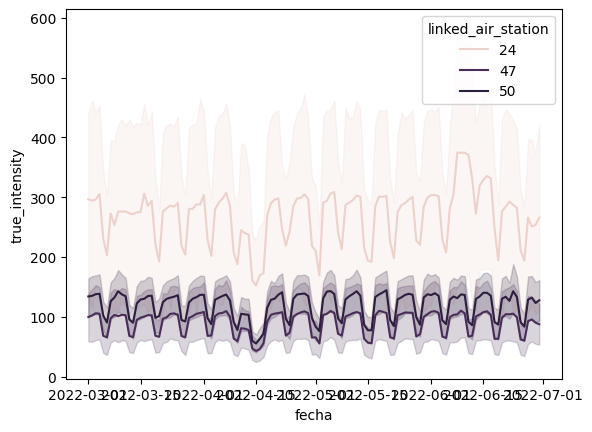

In [42]:
sns.lineplot(data =combined_df[combined_df.ANO == 2022], x = 'fecha', y ='true_intensity',
             hue = "linked_air_station")


<AxesSubplot: xlabel='fecha', ylabel='true_intensity'>

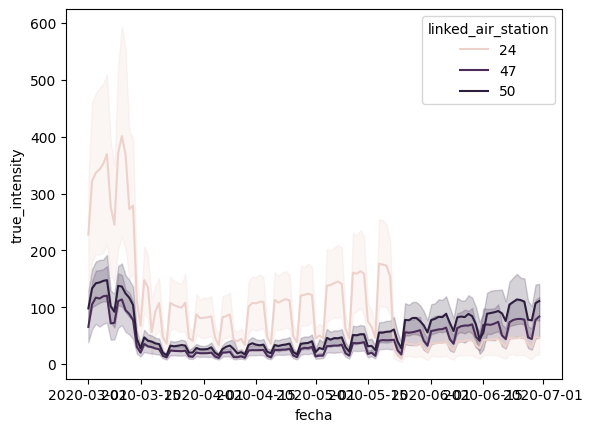

In [41]:
sns.lineplot(data =combined_df[combined_df.ANO == 2020], x = 'fecha', y ='true_intensity',
             hue = "linked_air_station")


<AxesSubplot: xlabel='fecha', ylabel='true_intensity'>

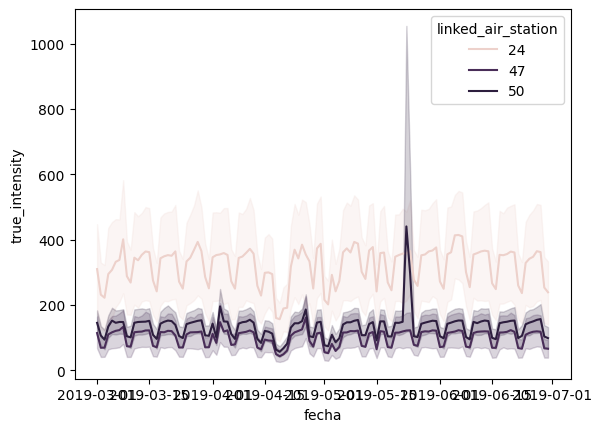

In [40]:
sns.lineplot(data =combined_df[combined_df.ANO == 2019], x = 'fecha', y ='true_intensity',
             hue = "linked_air_station")


In [667]:
dfmean['fecha'] = pd.to_datetime(dfmean.fecha)
dfmean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha               983 non-null    datetime64[ns]
 1   id                  983 non-null    int64         
 2   true_intensity      983 non-null    float64       
 3   linked_air_station  983 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 30.8 KB


In [444]:
dfnomean.id.unique()

array([3681, 3684, 3797, 3798, 3799, 3800, 3801, 3807, 3808, 3815, 3816,
       4072, 4123, 4124])

In [445]:
df19.linked_air_station.unique()

array([24, 47])

In [653]:
filepath = "/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/2022-09-madrid-trafficcsv.csv"
dfnomean , dfmean  = clean_monthly_traffic(filepath)

Dropping 12075394


In [654]:
dfmean

,fecha,id,true_intensity,linked_air_station
0,2022-09-01,1001,210.843750,24
1,2022-09-01,1002,166.687500,24
2,2022-09-01,1006,226.687500,24
3,2022-09-01,3421,177.500000,50
4,2022-09-01,3453,184.125000,50
...,...,...,...,...
975,2022-09-30,7004,152.002604,47
976,2022-09-30,7017,215.572917,50
977,2022-09-30,7023,47.348958,47
978,2022-09-30,7076,213.934896,47


In [656]:
dfmean.linked_air_station.unique()

array([24, 50, 47])

In [413]:
df.id.unique()

array([    1001,     1002,     1003, ...,    11029,    11030, 50335653])

In [369]:
df.id.unique()

array([3681, 3684, 3797, 3798, 3799, 3800, 3801, 3807, 3808, 3815, 3816,
       4123, 4124])

In [365]:
df.linked_air_station.unique()

array([24, 47])

In [361]:
df.groupby(['fecha', 'linked_air_station']).agg({'true_intensity' : ['mean']})

true_intensity
                                        mean
fecha      linked_air_station               
2022-09-01 24                      56.811994
           47                     375.190243
2022-09-02 24                      59.140225
           47                     368.425758
2022-09-03 24                      47.367491
           47                     287.645255
2022-09-04 24                      44.624555
           47                     265.503472
2022-09-05 24                      60.287325
           47                     375.090994
2022-09-06 24                      59.549349
           47                     382.103986
2022-09-07 24                      59.745482
           47                     375.302446
2022-09-08 24                      62.496068
           47                     387.404090
2022-09-09 24                      64.156456
           47                     391.515148
2022-09-10 24                      51.125178
           47                     302.042245
2022-09-11 24                      51.015065
           47                     298.173032
2022-09-12 24                      59.825061
           47                     379.426748
2022-09-13 24                      61.305186
           47                     365.557621
2022-09-14 24                      59.289545
           47                     381.907292
2022-09-15 24                      60.692612
           47                     389.003465
2022-09-16 24                      64.760194
           47                     395.381528
2022-09-17 24                      52.559186
           47                     316.342879
2022-09-18 24                      46.253057
           47                     299.326716
2022-09-19 24                      60.431255
           47                     372.237464
2022-09-20 24                      60.727755
           47                     391.961809
2022-09-21 24                      61.891775
           47                     391.109817
2022-09-22 24                      63.155660
           47                     387.425939
2022-09-23 24                      64.176940
           47                     392.863532
2022-09-24 24                      53.838932
           47                     311.620495
2022-09-25 24                      52.737565
           47                     284.979388
2022-09-26 24                      61.034021
           47                     358.094710
2022-09-27 24                      63.032924
           47                     366.610820
2022-09-28 24                      62.163685
           47                     408.616947
2022-09-29 24                      65.516797
           47                     378.025389
2022-09-30 24                      67.941778
           47                     392.970423

In [354]:
df[(df.linked_air_station == 24) & (df.id == 4124)]

,fecha,id,true_intensity,linked_air_station
12,2022-09-01,4124,76.273438,24
25,2022-09-02,4124,80.783854,24
38,2022-09-03,4124,60.356771,24
51,2022-09-04,4124,57.906250,24
64,2022-09-05,4124,80.869681,24
77,2022-09-06,4124,81.401042,24
90,2022-09-07,4124,81.231771,24
103,2022-09-08,4124,85.731771,24
116,2022-09-09,4124,88.302083,24
129,2022-09-10,4124,66.690104,24


In [330]:
df.id

854922     3681
854923     3681
854924     3681
854925     3681
854926     3681
           ... 
1982659    4124
1982660    4124
1982661    4124
1982662    4124
1982663    4124
Name: id, Length: 35775, dtype: int64

In [332]:
df[(df['id'] == 3681) &  (df['fecha'] == datetime.date(2022, 9, 1))]

,id,fecha,intensidad,error,true_intensity,linked_air_station
854922,3681,2022-09-01,101,N,25.25,24
854923,3681,2022-09-01,78,N,19.50,24
854924,3681,2022-09-01,55,N,13.75,24
854925,3681,2022-09-01,30,N,7.50,24
854926,3681,2022-09-01,14,N,3.50,24
...,...,...,...,...,...,...
855013,3681,2022-09-01,181,N,45.25,24
855014,3681,2022-09-01,126,N,31.50,24
855015,3681,2022-09-01,141,N,35.25,24
855016,3681,2022-09-01,101,N,25.25,24


In [324]:
df.groupby(['fecha', 'id']).aggregate({'true_intensity': ['mean']}).reset_index().columns.droplevel(0)

Index(['', '', 'mean'], dtype='object')

In [326]:
testtt = df.groupby(['fecha', 'id']).aggregate({'true_intensity': ['mean']}).reset_index()
testtt

,fecha,id,true_intensity
,,,mean
0,2022-09-01,3681,47.716146
1,2022-09-01,3684,77.638021
2,2022-09-01,3797,23.302083
3,2022-09-01,3798,247.705729
4,2022-09-01,3799,932.552083
...,...,...,...
385,2022-09-30,3808,37.002604
386,2022-09-30,3815,587.243243
387,2022-09-30,3816,621.827128


In [329]:
testtt[testtt['id'] == 3681]

,fecha,id,true_intensity
,,,mean
0,2022-09-01,3681,47.716146
13,2022-09-02,3681,49.455729
26,2022-09-03,3681,47.539062
39,2022-09-04,3681,41.205729
52,2022-09-05,3681,50.385417
65,2022-09-06,3681,49.677083
78,2022-09-07,3681,49.489583
91,2022-09-08,3681,49.236979
104,2022-09-09,3681,50.393229


In [313]:
df[(df['id'] == 3681)]

,id,fecha,intensidad,error,true_intensity,linked_air_station
854922,3681,2022-09-01,101,N,25.25,24
854923,3681,2022-09-01,78,N,19.50,24
854924,3681,2022-09-01,55,N,13.75,24
854925,3681,2022-09-01,30,N,7.50,24
854926,3681,2022-09-01,14,N,3.50,24
...,...,...,...,...,...,...
857790,3681,2022-09-30,255,N,63.75,24
857791,3681,2022-09-30,254,N,63.50,24
857792,3681,2022-09-30,163,N,40.75,24
857793,3681,2022-09-30,130,N,32.50,24


In [316]:
df.fecha.iloc[0]

datetime.date(2022, 9, 1)

In [310]:
df.fecha

854922     2022-09-01
854923     2022-09-01
854924     2022-09-01
854925     2022-09-01
854926     2022-09-01
              ...    
1982659    2022-09-30
1982660    2022-09-30
1982661    2022-09-30
1982662    2022-09-30
1982663    2022-09-30
Name: fecha, Length: 35775, dtype: object

In [301]:
df.drop(columns=['tipo_elem', 'ocupacion', 'carga', 'vmed', 'periodo_integracion'])

,id,fecha,intensidad,error,true_intensity,linked_air_station
854922,3681,2022-09-01,101,N,25.25,24
854923,3681,2022-09-01,78,N,19.50,24
854924,3681,2022-09-01,55,N,13.75,24
854925,3681,2022-09-01,30,N,7.50,24
854926,3681,2022-09-01,14,N,3.50,24
...,...,...,...,...,...,...
1982659,4124,2022-09-30,381,N,95.25,24
1982660,4124,2022-09-30,308,N,77.00,24
1982661,4124,2022-09-30,320,N,80.00,24
1982662,4124,2022-09-30,247,N,61.75,24


In [293]:
def linked_air_station(traffic_station_id):
    if traffic_station_id in closest_traffic_to_air_station_dict[24]:
        result_air_station = 24
    elif traffic_station_id in closest_traffic_to_air_station_dict[47]:
        result_air_station = 47
    elif traffic_station_id in closest_traffic_to_air_station_dict[50]:
        result_air_station = 50
    return result_air_station

In [294]:
np.vectorize(linked_air_station)(df['id'])

array([24, 24, 24, ..., 24, 24, 24])

In [290]:
df

,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion,true_intensity
854922,3681,2022-09-01,URB,101,1.0,11,0.0,N,15,25.25
854923,3681,2022-09-01,URB,78,0.0,9,0.0,N,15,19.50
854924,3681,2022-09-01,URB,55,0.0,8,0.0,N,15,13.75
854925,3681,2022-09-01,URB,30,0.0,4,0.0,N,15,7.50
854926,3681,2022-09-01,URB,14,0.0,2,0.0,N,15,3.50
...,...,...,...,...,...,...,...,...,...,...
1982659,4124,2022-09-30,URB,381,4.0,25,0.0,N,15,95.25
1982660,4124,2022-09-30,URB,308,3.0,21,0.0,N,15,77.00
1982661,4124,2022-09-30,URB,320,4.0,22,0.0,N,15,80.00
1982662,4124,2022-09-30,URB,247,2.0,18,0.0,N,15,61.75


<AxesSubplot: xlabel='fecha', ylabel='true_intensity'>

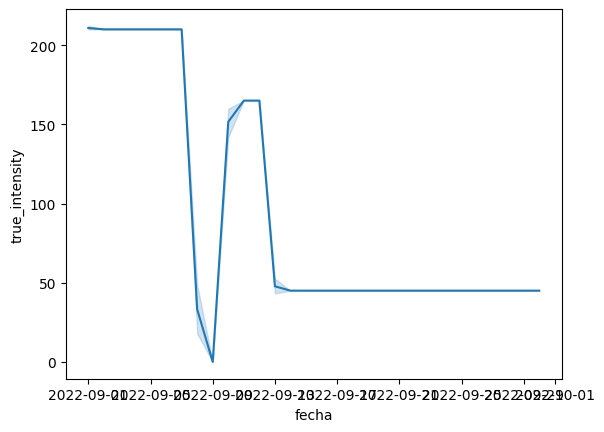

In [50]:
test_df = df[df['id'] == 1001]
sns.lineplot(data =test_df, x = 'fecha', y = 'true_intensity')


In [47]:
df.groupby(['id', 'fecha']).aggregate({'true_intensity': ['mean']})

true_intensity
                              mean
id       fecha                    
1001     2022-09-01     210.843750
         2022-09-02     210.000000
         2022-09-03     210.000000
         2022-09-04     210.000000
         2022-09-05     210.000000
...                            ...
11028    2022-09-30     177.255208
11029    2022-09-29     248.928571
         2022-09-30     180.789062
11030    2022-09-30      87.186567
50335653 2022-09-03      20.000000

[130354 rows x 1 columns]

## Compute Distance between each traffic station and 3 selected air stations

In [59]:
air_station_df = pd.read_csv('/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/air/212629-1-estaciones-control-aire.csv',
                             sep = ';')
selected_air_station_index = [24,47,50]
air_station_df = air_station_df[air_station_df['CODIGO_CORTO'].isin(selected_air_station_index)]

In [60]:
air_station_df

,CODIGO,CODIGO_CORTO,ESTACION,DIRECCION,LONGITUD_ETRS89,LATITUD_ETRS89,ALTITUD,COD_TIPO,NOM_TIPO,NO2,...,BTX,COD_VIA,VIA_CLASE,VIA_PAR,VIA_NOMBRE,Fecha alta,COORDENADA_X_ETRS89,COORDENADA_Y_ETRS89,LONGITUD,LATITUD
6,28079024,24,Casa de Campo,Casa de Campo (Terminal del Teleférico),"3°44'50.44""O","40°25'9.69""N",646,S,Suburbana,X,...,X,905219,CARRETERA,DEL,TELEFERICO,01/12/1998,"436598,5637","4474571,618",-3.747345,40.419358
13,28079047,47,Méndez Álvaro,C/ Juan de Mariana / Plaza Amanecer Méndez Álvaro,"3°41'12.57""O","40°23'53.17""N",600,UF,Urbana fondo,X,...,NaN,414800,CALLE,DE,JUAN DE MARIANA,21/12/2009,"441715,4303","4472170,249",-3.686814,40.398099
16,28079050,50,Plaza Castilla,Plaza Castilla (Canal),"3°41'19.48""O","40°27'56.10""N",728,UT,Urbana tráfico,X,...,NaN,154500,PLAZA,DE,CASTILLA,01/02/2010,"441609,9474","4479662,346",-3.688745,40.465584


In [64]:
traffic_station_df_2022 = pd.read_csv('/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/2022-madrid-sensor-location.csv',
                                 sep = ';')
len(traffic_station_df_2022.id.unique())

4663

In [579]:
traffic_station_df_2019 = pd.read_csv('/Users/carlosito/Library/CloudStorage/OneDrive-Personal/AIT material/DANIclass/2-Iot/Project/Madrid/traffic/202468-40-intensidad-trafico-station.csv',
                                 sep = ';')
len(traffic_station_df_2019.id.unique())

4154

To make the comparison among 3 years consistent, we'll select only the traffic stations from 2019

In [588]:
output_matrix = np.zeros((len(selected_air_station_index), len(traffic_station_df_2019.id.unique())))

for air_station_idx in range(len(selected_air_station_index)):
    for traffic_station_idx in range(len(traffic_station_df_2019.id.unique())):
        # print(air_station_idx, traffic_station_idx)
        geo_a = air_station_df.iloc[air_station_idx]['LATITUD'] ,air_station_df.iloc[air_station_idx]['LONGITUD']
        geo_b = traffic_station_df_2019.iloc[traffic_station_idx]['latitud'] ,traffic_station_df_2019.iloc[traffic_station_idx]['longitud'] 
        
        
        
        distance = GD(geo_a, geo_b).km
        # # 
        output_matrix[air_station_idx][traffic_station_idx] = distance
        
        # print(f"{meteo_station_idx}, {air_station_idx } : {distance} ")

In [542]:
traffic_station_df_2019.iloc[traffic_station_idx]

tipo_elem               M30
distrito               16.0
id                     7015
cod_cent            PM43223
nombre              PM43223
utm_x         443019.864262
utm_y        4481807.057614
longitud          -3.672308
latitud           40.485002
Name: 4153, dtype: object

In [592]:
output_matrix[0][output_matrix[0] < 1.5]

array([1.41292275, 1.19647864, 1.43440153, 1.24974493, 1.20541255,
       1.29417185, 1.39241483, 1.18122384, 1.38263532, 1.42729187,
       1.39454804, 1.39540589, 1.31781641, 1.27383262, 1.30391303,
       1.32616811, 1.27541947, 1.4233305 , 1.30989376, 1.35002941,
       1.3988724 , 1.26335264, 1.27559079, 1.29437907])

In [543]:
for_plot_air = air_station_df[['ESTACION', 'LATITUD', 'LONGITUD']]
for_plot_air['station_type'] = 'air'
for_plot_air['for_reference_plot'] = 'air station'

for_plot_traffic = traffic_station_df_2019[['id', 'latitud', 'longitud']]
for_plot_traffic['station_type'] = 'traffic'
for_plot_traffic.rename(columns={'id': "ESTACION",
                                 'latitud': 'LATITUD',
                                 'longitud': 'LONGITUD'}, inplace= True)
for_plot_traffic['for_reference_plot'] = for_plot_traffic.ESTACION


for_plot_both = pd.concat([for_plot_air, for_plot_traffic])

/var/folders/tl/rdcj6pp130g_pdpr6thc58qr0000gn/T/ipykernel_26133/3067768394.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/tl/rdcj6pp130g_pdpr6thc58qr0000gn/T/ipykernel_26133/3067768394.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/tl/rdcj6pp130g_pdpr6thc58qr0000gn/T/ipykernel_26133/3067768394.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [617]:
for_plot_air = air_station_df[['ESTACION', 'LATITUD', 'LONGITUD']]
for_plot_air['station_type'] = 'air'
for_plot_air['for_reference_plot'] = 'air station'

for_plot_traffic = traffic_station_df_2019[['id', 'latitud', 'longitud']]
for_plot_traffic['station_type'] = 'traffic'
for_plot_traffic.rename(columns={'id': "ESTACION",
                                 'latitud': 'LATITUD',
                                 'longitud': 'LONGITUD'}, inplace= True)
for_plot_traffic['for_reference_plot'] = np.arange(len(traffic_station_df_2019))


for_plot_both = pd.concat([for_plot_air, for_plot_traffic])

/var/folders/tl/rdcj6pp130g_pdpr6thc58qr0000gn/T/ipykernel_26133/1902621965.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/tl/rdcj6pp130g_pdpr6thc58qr0000gn/T/ipykernel_26133/1902621965.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/tl/rdcj6pp130g_pdpr6thc58qr0000gn/T/ipykernel_26133/1902621965.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [544]:
for_plot_both

,ESTACION,LATITUD,LONGITUD,station_type,for_reference_plot
6,Casa de Campo,40.419358,-3.747345,air,air station
13,Méndez Álvaro,40.398099,-3.686814,air,air station
16,Plaza Castilla,40.465584,-3.688745,air,air station
0,3840,40.430502,-3.688323,traffic,3840
1,3841,40.430524,-3.687256,traffic,3841
...,...,...,...,...,...
4149,6809,40.483080,-3.659954,traffic,6809
4150,6810,40.483158,-3.659926,traffic,6810
4151,6933,40.484118,-3.672497,traffic,6933
4152,7129,40.484181,-3.672500,traffic,7129


In [619]:
fig = px.scatter_mapbox(for_plot_both,
                     lat='LATITUD',lon='LONGITUD',
                     hover_name="ESTACION",
                     zoom=10, 
                     height=500,
                     width=1000,
                     color = "station_type",
                     )
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_traces(marker={'size': 5})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [485]:
pd.DataFrame(output_matrix[0]).describe()

,0
count,4154.000000
mean,6.926931
std,2.764267
min,1.181224
25%,4.872898
50%,6.757453
75%,8.797281
max,15.413099


In [546]:
output_matrix[0][output_matrix[0] < 1.3]

array([1.19647864, 1.24974493, 1.20541255, 1.29417185, 1.18122384,
       1.27383262, 1.27541947, 1.26335264, 1.27559079, 1.29437907])

In [594]:
distance_threshold = [1.3, 0.4 ,0.3]
closest_traffic_to_air_station_dict = {}
all_pass_threshold_index = []
all_pass_threshold_station= []

for i in range(len(selected_air_station_index)):
    theshold_pass_index = [a for a in range(len(output_matrix[i])) if output_matrix[i][a] < distance_threshold[i]]
    print(len(theshold_pass_index))
    print(theshold_pass_index)
    
    threshold_pass_station =for_plot_both.iloc[theshold_pass_index].ESTACION.tolist()
    
    print(output_matrix[i][theshold_pass_index])
    print(threshold_pass_station)
    print()
    closest_traffic_to_air_station_dict[f"{air_station_df.iloc[i]['CODIGO_CORTO']}_index"] = theshold_pass_index
    closest_traffic_to_air_station_dict[f"{air_station_df.iloc[i]['CODIGO_CORTO']}_station"]  = threshold_pass_station
    all_pass_threshold_index.extend(theshold_pass_index)
    all_pass_threshold_station.extend(threshold_pass_station)
    


10
[138, 140, 172, 173, 772, 3681, 3684, 4072, 4123, 4124]
[1.19647864 1.24974493 1.20541255 1.29417185 1.18122384 1.27383262
 1.27541947 1.26335264 1.27559079 1.29437907]
[10076, 3544, 10048, 10049, 6837, 5023, 5031, 6778, 6793, 6823]

9
[3797, 3798, 3799, 3800, 3801, 3807, 3808, 3815, 3816]
[0.37629716 0.32447304 0.26717018 0.15232417 0.3619918  0.25199808
 0.3535592  0.39376339 0.27055806]
[4130, 4154, 7002, 4153, 7003, 4056, 4051, 4137, 7100]

14
[1196, 1242, 2416, 2417, 2433, 2436, 2485, 2491, 2492, 2501, 2502, 2503, 2614, 2634]
[0.1798439  0.2584375  0.15660009 0.25501273 0.14856397 0.20863855
 0.22531776 0.15895152 0.28128257 0.18105314 0.29692319 0.26725129
 0.2756159  0.26198234]
[4578, 4617, 6386, 6967, 5462, 5465, 5511, 7080, 7081, 5522, 5523, 5524, 5582, 5636]



In [595]:
for_plot_both.iloc[1196]

ESTACION                                  4578
LATITUD                              40.467571
LONGITUD                             -3.692685
station_type                           traffic
for_reference_plot                        4578
station_usage_check       Used traffic station
station_usage_check2    Unused traffic station
Name: 1193, dtype: object

In [596]:
output_matrix[-1][all_pass_threshold_index]

array([7.63132691, 7.20001975, 7.6134678 , 7.91415334, 7.60892754,
       7.42657351, 7.60977238, 7.86370488, 7.86525667, 7.88518336,
       7.58403982, 7.50258217, 7.44929842, 7.37490042, 7.23199573,
       7.3539383 , 7.14225674, 7.58861406, 7.25060887, 0.1798439 ,
       0.2584375 , 0.15660009, 0.25501273, 0.14856397, 0.20863855,
       0.22531776, 0.15895152, 0.28128257, 0.18105314, 0.29692319,
       0.26725129, 0.2756159 , 0.26198234])

In [597]:
print(len(all_pass_threshold_index))
print(len(all_pass_threshold_station))

33
33


In [503]:
for_plot_both[for_plot_both.for_reference_plot.isin([1196, 1242, 2416, 2417, 2433, 2436, 2485, 2491, 2492, 2501, 2502, 2503, 2614, 2634])].ESTACION.tolist()

[]

In [510]:
for_plot_both.iloc[[1196, 1242, 2416, 2417, 2433, 2436, 2485, 2491, 2492, 2501, 2502, 2503, 2614, 2634]].ESTACION

1193    4578
1239    4617
2413    6386
2414    6967
2430    5462
2433    5465
2482    5511
2488    7080
2489    7081
2498    5522
2499    5523
2500    5524
2611    5582
2631    5636
Name: ESTACION, dtype: object

In [598]:
sth = traffic_station_df_2019[traffic_station_df_2019.id.isin(all_pass_threshold_station)]

fig = px.scatter_mapbox(sth,
                     lat='latitud',lon='longitud',
                     hover_name="id",
                     zoom=10, 
                     height=500,
                     width=1000,
                     color_discrete_sequence= px.colors.qualitative.Alphabet
                     )
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_traces(marker={'size': 7})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [497]:
for_plot_both[for_plot_both.for_reference_plot.isin(theshold_pass_index)].ESTACION.tolist()

[]

In [558]:
print(closest_traffic_to_air_station_dict["47_index"])
print(closest_traffic_to_air_station_dict["47_station"])

[3797, 3798, 3799, 3800, 3801, 3807, 3808, 3815, 3816]
[4130, 4154, 7002, 4153, 7003, 4056, 4051, 4137, 7100]


In [530]:
closest_traffic_to_air_station_list = []
for a, i in closest_traffic_to_air_station_dict.items():
    closest_traffic_to_air_station_list.extend(i)


In [531]:
len(closest_traffic_to_air_station_list)

66

In [518]:
print(len(all_pass_threshold_station))
print(len(set(all_pass_threshold_station)))

14
14


In [560]:
def check_usage(reference_station_index):
    if type(reference_station_index) == int:
        if reference_station_index in all_pass_threshold_station:
            status = 'Used traffic station'
        else:
            status = 'Unused traffic station'
    else:
        status = 'Air station'
    return status

In [566]:
np.sort(all_pass_threshold_station)

array([ 3544,  4051,  4056,  4130,  4137,  4153,  4154,  4578,  4617,
        5023,  5031,  5462,  5465,  5511,  5522,  5523,  5524,  5582,
        5636,  6386,  6778,  6793,  6823,  6837,  6967,  7002,  7003,
        7080,  7081,  7100, 10048, 10049, 10076])

In [607]:
np.vectorize(check_usage)(655)

array('Unused traffic station', dtype='<U22')

In [571]:
def check_usage2(reference_station_index):
    if type(reference_station_index) == int:
        if reference_station_index in all_pass_threshold_index:
            status = 'Used traffic station'
        else:
            status = 'Unused traffic station'
    else:
        status = 'Air station'
    return status

In [621]:
np.vectorize(check_usage2)(for_plot_both['for_reference_plot'])

array(['Air station', 'Air station', 'Air station', ...,
       'Unused traffic station', 'Unused traffic station',
       'Unused traffic station'], dtype='<U22')

In [622]:
for_plot_both['station_usage_check'] = np.vectorize(check_usage)(for_plot_both['for_reference_plot'])
for_plot_both['station_usage_check2'] = np.vectorize(check_usage2)(for_plot_both['for_reference_plot'])

In [632]:
CORRECT_USED_STATION = for_plot_both[for_plot_both['station_usage_check2'] == 'Used traffic station'].ESTACION.to_list()
len(CORRECT_USED_STATION)

33

In [633]:
CORRECT_USED_STATION

[3545,
 1006,
 1001,
 1002,
 3546,
 4581,
 4620,
 3421,
 7017,
 5465,
 5468,
 3449,
 5515,
 5516,
 5525,
 5526,
 5527,
 3453,
 5639,
 5031,
 5009,
 4153,
 7003,
 7004,
 4129,
 4126,
 7076,
 7023,
 7083,
 4127,
 6780,
 6794,
 6936]

In [631]:
all_pass_threshold_station

[10076,
 3544,
 10048,
 10049,
 6837,
 5023,
 5031,
 6778,
 6793,
 6823,
 4130,
 4154,
 7002,
 4153,
 7003,
 4056,
 4051,
 4137,
 7100,
 4578,
 4617,
 6386,
 6967,
 5462,
 5465,
 5511,
 7080,
 7081,
 5522,
 5523,
 5524,
 5582,
 5636]

In [627]:
for_plot_both[for_plot_both['station_usage_check2'] == 'Used traffic station']

,ESTACION,LATITUD,LONGITUD,station_type,for_reference_plot,station_usage_check,station_usage_check2
138,3545,40.409700,-3.741094,traffic,138,Unused traffic station,Used traffic station
140,1006,40.411894,-3.736324,traffic,140,Unused traffic station,Used traffic station
172,1001,40.409729,-3.740786,traffic,172,Unused traffic station,Used traffic station
173,1002,40.408030,-3.743760,traffic,173,Unused traffic station,Used traffic station
772,3546,40.409893,-3.740993,traffic,772,Unused traffic station,Used traffic station
1196,4581,40.466635,-3.690358,traffic,1196,Unused traffic station,Used traffic station
1242,4620,40.467761,-3.687666,traffic,1242,Unused traffic station,Used traffic station
2416,3421,40.465693,-3.690586,traffic,2416,Unused traffic station,Used traffic station
2417,7017,40.467853,-3.689208,traffic,2417,Unused traffic station,Used traffic station
2433,5465,40.464276,-3.689110,traffic,2433,Unused traffic station,Used traffic station


In [657]:
fig = px.scatter_mapbox(for_plot_both,
                     lat='LATITUD',lon='LONGITUD',
                     hover_name="ESTACION",
                     zoom=10, 
                     height=500,
                     width=500,
                     color = "station_usage_check2",
                     color_discrete_sequence= px.colors.qualitative.Alphabet
                     )
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_traces(marker={'size': 20})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [658]:
fig = px.scatter_mapbox(for_plot_both,
                     lat='LATITUD',lon='LONGITUD',
                     hover_name="ESTACION",
                     zoom=10, 
                     height=500,
                     width=700,
                     color = "station_usage_check2",
                     color_discrete_sequence= px.colors.qualitative.Alphabet
                     )
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_traces(marker={'size': 20})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [18]:
closest_traffic_to_air_station_dict[50]

[5465,
 5639,
 5468,
 3453,
 3421,
 4581,
 3449,
 7017,
 4620,
 5525,
 5515,
 5526,
 5516,
 5527]

In [573]:
for_plot_both.head()

,ESTACION,LATITUD,LONGITUD,station_type,for_reference_plot,station_usage_check,station_usage_check2
6,Casa de Campo,40.419358,-3.747345,air,air station,Air station,Air station
13,Méndez Álvaro,40.398099,-3.686814,air,air station,Air station,Air station
16,Plaza Castilla,40.465584,-3.688745,air,air station,Air station,Air station
0,3840,40.430502,-3.688323,traffic,3840,Unused traffic station,Unused traffic station
1,3841,40.430524,-3.687256,traffic,3841,Unused traffic station,Unused traffic station


In [575]:
used_traffic_[ 138,  140,  172,  173,  772, 1196, 1242, 2416, 2417, 2433, 2436,
            2485, 2491, 2492, 2501, 2502, 2503, 2614, 2634, 3681, 3684, 3797,
            3798, 3799, 3800, 3801, 3807, 3808, 3815, 3816, 4072, 4123, 4124]

NameError: name 'used_traffic_' is not defined

In [578]:
fig = px.scatter_mapbox(for_plot_both,
                     lat='LATITUD',lon='LONGITUD',
                     hover_name="ESTACION",
                     zoom=10, 
                     height=500,
                     width=1000,
                     color = "station_usage_check",
                     color_discrete_sequence= px.colors.qualitative.Alphabet
                     )
fig.update_layout(mapbox_style="stamen-terrain")
fig.update_traces(marker={'size': 7})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()